<a href="https://colab.research.google.com/github/zar7364/DataScience/blob/main/Audio_Heart_Classification_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
%%time
dataset = []
for folder in ["/content/drive/My Drive/Colab Notebooks/AudioMapping/set_a/**","/content/drive/My Drive/Colab Notebooks/AudioMapping/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)


CPU times: user 5.43 s, sys: 15 s, total: 20.4 s
Wall time: 1min 47s


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


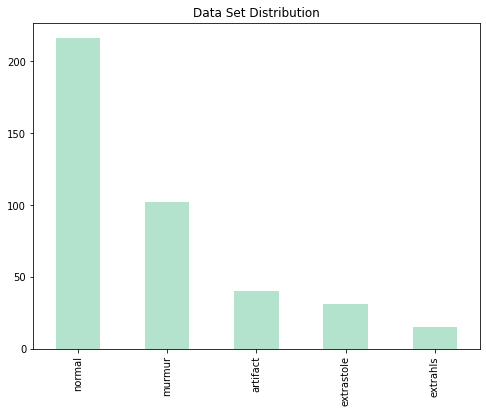

In [17]:
plt.figure(figsize=(8,6))
dataset.label.value_counts().plot(kind="bar",cmap="Pastel2",title="Data Set Distribution",label=True)
plt.show()

In [19]:
#Split dataset

train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 323
Test: 81


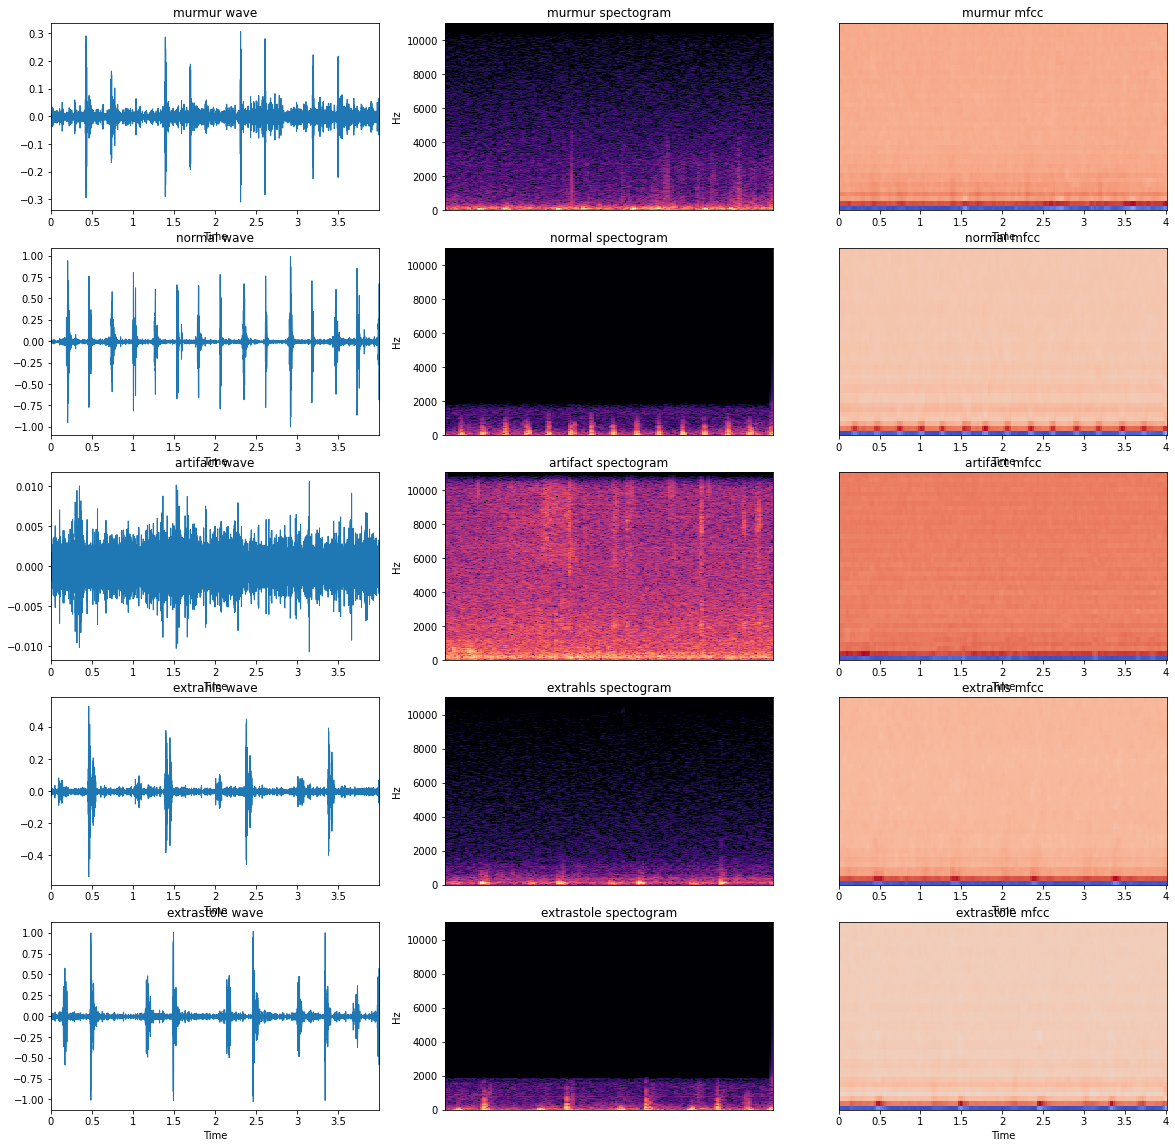

CPU times: user 3.5 s, sys: 428 ms, total: 3.93 s
Wall time: 4.2 s


In [20]:
#Show audio Info

%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()

In [21]:
#Extract Feature From Audio
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [22]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 0/323 [00:00<?, ?it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 81/81 [00:20<00:00,  3.90it/s]

X train: (323, 40, 173)
X test: (81, 40, 173)
CPU times: user 52.4 s, sys: 12.5 s, total: 1min 4s
Wall time: 1min 40s


In [23]:
#Ecode Labels

%%time
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

CPU times: user 989 µs, sys: 0 ns, total: 989 µs
Wall time: 997 µs


In [24]:
#Compute class weights

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [25]:
#Input Shape

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 173, 1)
Y train: (323, 5)

X test: (81, 40, 173, 1)
Y test: (81, 5)


In [26]:
#Build Model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

In [27]:
#Compile Model

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [31]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/300
3/3 [==============================] - 1s 358ms/step - loss: 0.5479 - accuracy: 0.7833 - val_loss: 0.7363 - val_accuracy: 0.6667
Epoch 2/300
3/3 [==============================] - 1s 303ms/step - loss: 0.5119 - accuracy: 0.7771 - val_loss: 0.7423 - val_accuracy: 0.6667
Epoch 3/300
3/3 [==============================] - 1s 309ms/step - loss: 0.5259 - accuracy: 0.7926 - val_loss: 0.7434 - val_accuracy: 0.6790
Epoch 4/300
3/3 [==============================] - 1s 304ms/step - loss: 0.4987 - accuracy: 0.7957 - val_loss: 0.7408 - val_accuracy: 0.6790
Epoch 5/300
3/3 [==============================] - 1s 303ms/step - loss: 0.5372 - accuracy: 0.7833 - val_loss: 0.7480 - val_accuracy: 0.6790
Epoch 6/300
3/3 [==============================] - 1s 310ms/step - loss: 0.5096 - accuracy: 0.7864 - val_loss: 0.7463 - val_accuracy: 0.6667
Epoch 7/300
3/3 [==============================] - 1s 311ms/step - loss: 0.5168 - accuracy: 0.7895 - val_loss: 0.7448 - val_accuracy: 0.6420
Epoch 8/300
3

Text(0.5, 1.0, 'Accuracy Curves')

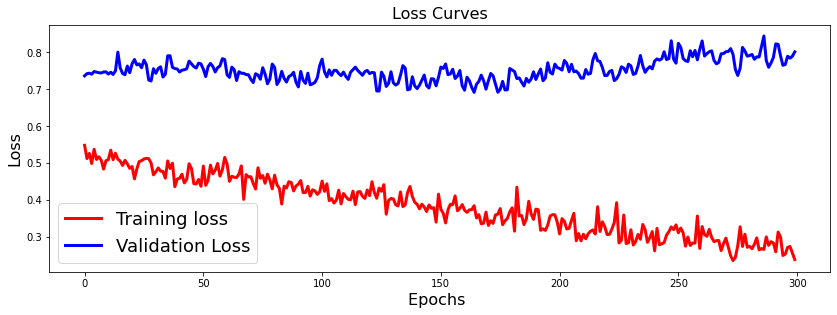

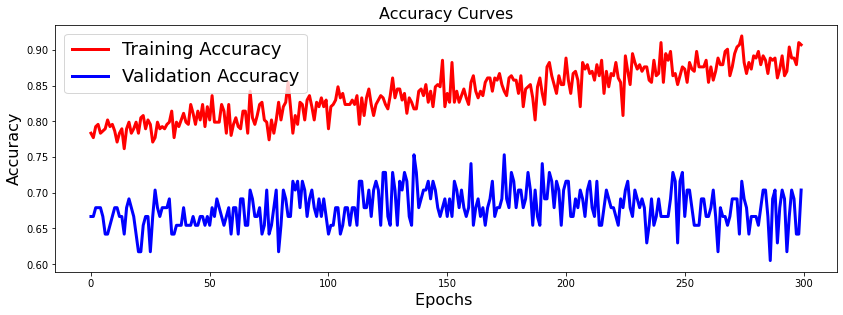

In [33]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [34]:
# Save model and weights
model_name = "heartbeat_disease.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at heartbeat_disease.h5 


In [35]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 23ms/step - loss: 0.8013 - accuracy: 0.7037
Test loss: 0.8012834787368774
Test accuracy: 0.7037037014961243


In [36]:
#Classification Report

predictions = model.predict(x_test, verbose=1)

3/3 [==============================] - 0s 22ms/step


In [37]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

In [38]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

    artifact       1.00      0.90      0.95        10
    extrahls       0.50      0.67      0.57         3
  extrastole       0.33      0.17      0.22         6
      murmur       0.52      0.71      0.60        17
      normal       0.79      0.73      0.76        45

    accuracy                           0.70        81
   macro avg       0.63      0.63      0.62        81
weighted avg       0.71      0.70      0.70        81



In [39]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()

    plt.show()

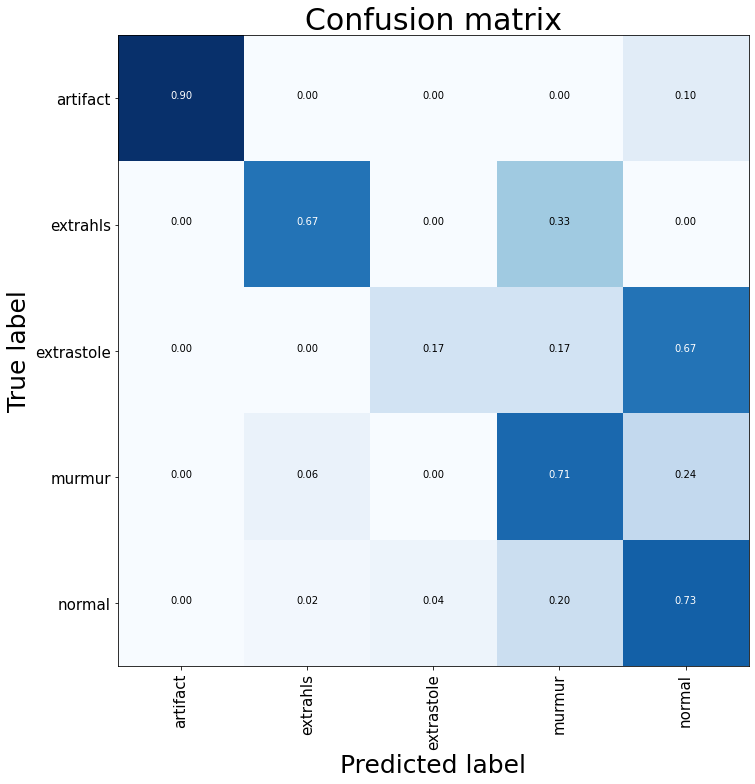

In [40]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)